<a href="https://colab.research.google.com/github/strongeryoung/class_SmartDataAnalysis/blob/main/Time_Series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 사전작업

## 모듈 임포트

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline
from matplotlib import rcParams
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
import seaborn as sns

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# [출처] [파이썬] colab에서 plt 한글깨짐 해결|작성자 서울시립대 통계학과

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔글꼴 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 12
# [출처] [파이썬] colab에서 plt 한글깨짐 해결|작성자 서울시립대 통계학과

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (15.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and direc

In [ ]:
pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

## 함수 설정

In [ ]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]

    tem_df = pd.DataFrame(Y_pred )
    tem_df.index = Y_real.index
    tem_df.columns = ['prediction']

    if graph_on == True:
        pd.concat([Y_real, tem_df], axis=1).plot(kind='line', figsize=(20,6), xlim=(Y_real.index.min(),Y_real.index.max()), linewidth=3, fontsize=15)
        plt.title('Time Series of Data', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)

    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred.values.flatten(), index=Y_real.index, columns=['Error'])

    return Score, Residual


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te


### Error analysis
def stationarity_adf_test(Y_Data, col_name):
    if len(col_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:2],
                                     index=['Statistics', 'p_value'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[col_name])[0:2],
                                     index=['Statistics', 'p_value'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[col_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[col_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])

    return Stationarity_adf

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):

    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', height=5.2, aspect=2, ci=99, sharey=True)

        # xticks와 yticks의 글자 크기 조절
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # X, Y 레이블 폰트 크기 조절
        plt.xlabel('Time', fontsize=14)  # X 레이블 폰트 크기 조절
        plt.ylabel('Error', fontsize=14)  # Y 레이블 폰트 크기 조절

        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)
        # xticks와 yticks의 글자 크기 조절
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # X, Y 레이블 폰트 크기 조절
        plt.xlabel('Error', fontsize=14)  # X 레이블 폰트 크기 조절
        plt.ylabel('Density', fontsize=14)  # Y 레이블 폰트 크기 조절

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=30, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=30, use_vlines=True, ax=axes[1])

        # xticks와 yticks의 글자 크기 조절
        axes[0].tick_params(axis='both', which='major', labelsize=12)
        axes[1].tick_params(axis='both', which='major', labelsize=12)

        # x축 레이블 및 y축 레이블의 제목 글자 크기 조절
        axes[0].set_xlabel('Lags', fontsize=12)
        axes[0].set_ylabel('ACF', fontsize=12)
        axes[1].set_xlabel('Lags', fontsize=12)
        axes[1].set_ylabel('PACF', fontsize=12)

        #타이틀 폰트 크기 조절
        axes[0].set_title('ACF Plot', fontsize=12)
        axes[1].set_title('PACF Plot', fontsize=12)
        # 서브플롯 간격 조절
        plt.subplots_adjust(hspace=1.0)  # 수직 간격 조절

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                              index=['Normality'], columns=['Statistics', 'p_value']).T

    # # Checking for Autocorrelation
    # # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])['lb_stat'], columns=['Test Statistics']),
                                  pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])['lb_pvalue'], columns=['p_value'])], axis=1).T

    Autocorrelation = sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])
    Autocorrelation.columns = ['Statistics', 'p_value']
    Autocorrelation_T = Autocorrelation.T
    Autocorrelation_T.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag20)', 'Autocorr(lag30)']

    # # # Checking Heteroscedasticity
    # # # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Statistics', 'p_value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Normality, Autocorrelation_T, Heteroscedasticity], join='outer', axis=1)

    return Score.round(3)

# 회귀모형의 평가 지표


## MAE, MSE, MAPE에 대하여

- **Mean Absolute Error(MAE):**
<center>$MAE = \dfrac{1}{n}$ $\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|$</center>


- **Mean Squared Error(MSE):** 가장 많이 사용 되는 지표
<center>$MSE = \dfrac{1}{n}$ $\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$</center>

- **Mean Absolute Percentage Error(MAPE):** MAE와 유사하나 퍼센트 형식으로 표시한 성능지표
<center>$MAPE = \dfrac{100}{n}$ $\sum\limits_{i=1}^{n} \dfrac{|y_i - \hat{y}_i|}{y_i}$</center>

회귀 모델의 평가지표로 사용되는 세 가지 지표인 MAE (Mean Absolute Error), MSE (Mean Squared Error), 그리고 MAPE (Mean Absolute Percentage Error)는 각각 모델의 예측 성능을 측정하는 데 사용됩니다.

1. **MAE (Mean Absolute Error):**
   - MAE는 예측값과 실제값 간의 절대적인 오차의 평균을 나타냅니다.
   - MAE는 다음과 같이 계산됩니다:
     \[ MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_{i} - \hat{Y}_{i}| \]
     여기서 \( n \)은 데이터 포인트의 수, \( Y_{i} \)는 실제값, \( \hat{Y}_{i} \)는 예측값입니다.
   - MAE는 오차를 모두 더한 후 평균을 내기 때문에 이상치(outliers)에 민감하지 않습니다.

2. **MSE (Mean Squared Error):**
   - MSE는 예측값과 실제값 간의 제곱 오차의 평균을 나타냅니다.
   - MSE는 다음과 같이 계산됩니다:
     \[ MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_{i} - \hat{Y}_{i})^2 \]
   - 제곱을 사용하기 때문에 오차의 크기가 크면 더 큰 패널티를 부과합니다. 따라서 MSE는 이상치에 민감할 수 있습니다.

3. **MAPE (Mean Absolute Percentage Error):**
   - MAPE는 예측값과 실제값 간의 백분율로 된 절대적인 오차의 평균을 나타냅니다.
   - MAPE는 다음과 같이 계산됩니다:
     \[ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left(\frac{|Y_{i} - \hat{Y}_{i}|}{|Y_{i}|}\right) \times 100 \]
   - MAPE는 예측 오차를 백분율로 표현하며, 예측 대상의 상대적인 정확도를 측정합니다. 하지만 실제값이 0인 경우에는 MAPE를 계산할 수 없습니다.
.


# 회귀모형의 잔차 진단 정리


### [정상성 테스트](https://en.wikipedia.org/wiki/Unit_root_test)

- [**Augmented Dickey-Fuller(ADF) test:**](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)
    - **가설확인**
        - **귀무가설, Null Hypothesis, H0:** 시계열 데이터는 단위근(Unit Root)이 존재한다 / 추세가 존재한다 / 시간의존 구조
        - **대립가설, Alternative Hypothesis, H1:** 시계열 데이터 단위근 없음 / 정상 상태, 시간의존 구조 아님
        - **의사결정**
        - **p-value >= critical value (ex. 0.05):**
        > **수집한(분석한) 시계열 데이터는 단위근 존재 / 비정상 상태 / 시간의존 구조**
        - **p-value < critical value:**
        > **수집한(분석한) 시계열 데이터는 단위근 없음 / 정상 상태 / 시간의존 구조가 아님**


### [정규분포 테스트(Normality Test)](https://en.wikipedia.org/wiki/Normality_test)

- [**Shapiro–Wilk test:**](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)
    - **가설확인**
        - **귀무가설, Null Hypothesis, H0:** 데이터는 정규분포 형태
        - **대립가설, Alternative Hypothesis, H1:** 데이터는 정규분포를 따르지 않음
    - **의사결정**
        - **p-value >= 내기준(ex. 0.05):**  
        >  데이터는 정규분포를 따르는 형태임
        - **p-value < 내기준(ex. 0.05):**
        >  데이터는 정규분포를 따르는 형태가 아님


- [**Jarque–Bera test:**](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test)
    - **가설확인:** Shapiro–Wilk와 동일

### 자기상관 테스트(Autocorrelation Test)

- [**Ljung–Box test:**](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)
    - **가설확인**
        - **귀무가설, Null Hypothesis, H0:** 시계열 데이터의 Autocorrelation은 0은 존재하지 않는다
        - **대립가설, Alternative Hypothesis, H1:** 시계열 데이터의 Autocorrelation은 존재한다
    - **의사결정**
        - **p-value >= 내기준(ex. 0.05):**
        > 분석대상 시계열 데이터의 Autocorrelation은 존재하지 않음
        - **p-value < 내기준(ex. 0.05):** 내가 수집한(분석한) 데이터가 대중주장을 벗어나기 때문에 대중주장 거짓 & 나의주장 참
        > 분석대상 시계열 데이터의 Autocorrelation은 존재

- [**Portmanteau test:**](https://en.wikipedia.org/wiki/Portmanteau_test)
    - **가설확인:** Ljung–Box와 동일

- [**Breusch–Godfrey test:**](https://en.wikipedia.org/wiki/Breusch%E2%80%93Godfrey_test)
    - **가설확인:** Ljung–Box와 동일
  
- [**Durbin–Watson statistic:**](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic)
    - **가설:** Ljung–Box와 동일
    - **의사결정:** 검정통계량 범위 - 0 과 4 사이
        - **검정 통계량 범이 2 근방:**
        > 시계열 데이터의 Autocorrelation은 존재하지 않음
        - **0 또는 4 근방:**
        > **시계열 데이터의 Autocorrelation은 존재**
            - 0: 양(Positive)의 Autocorrelation
            - 4: 음(Negative)의 Autocorrelation

### [등분산성 테스트(Homoscedasticity Test)](https://en.wikipedia.org/wiki/Homoscedasticity)

- [**Goldfeld–Quandt test:**](https://en.wikipedia.org/wiki/Goldfeld%E2%80%93Quandt_test)
    - **가설확인**
        - **귀무가설, Null Hypothesis, H0:** 시계열 데이터의 Homoscedasticity 상태이다 (등분산이다)
        - **대립가설, Alternative Hypothesis, H1:** 시계열 데이터의 Heteroscedasticity 상태다(등분산 또는 발산하는 형태의 분산)
    - **의사결정**
        - **p-value >= 내기준(ex. 0.05):**
        > 분석대상 시계열 데이터는 등분산이다
        - **p-value < 내기준(ex. 0.05):**
        > 분석대상 시계열 데이터는 등분산 아님

- [**Breusch–Pagan test:**](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test)
    - **가설확인:** Goldfeld–Quandt와 동일


# SARIMA모형의 이해

## SARIMA 모형이란?
#### (파이썬을활용한시계열데이터분석, 김경원, Fast Campus 강좌 인용)

SARIMA(Seasonal Autoregressive Integrated Moving Average) 모형은 시계열 데이터를 분석하고 예측하기 위한 통계적 모델입니다. ARIMA 모형의 확장으로, 시계열 데이터가 계절성 패턴을 가지고 있을 때 사용됩니다.

SARIMA 모형은 다음과 같은 구성요소로 이루어져 있습니다:

1. **AR(p) - Autoregressive Component (자기회귀)**: 현재 값이 과거 p개의 값에 의존하는 부분입니다. AR(p)은 시계열 데이터의 자기회귀 구조를 나타냅니다.

2. **I(d) - Integrated Component (차분)**: 시계열 데이터가 정상성(stationarity)을 만족하지 않을 경우, d번 차분을 적용하여 정상성을 확보하는 부분입니다. 이를 통해 추세나 계절성을 제거할 수 있습니다.

3. **MA(q) - Moving Average Component (이동평균)**: 현재 값이 과거 q개의 랜덤 오차에 의존하는 부분입니다. MA(q)는 시계열 데이터의 랜덤 요소를 나타냅니다.

4. **Seasonal AR(P) - Seasonal Autoregressive Component (계절 자기회귀)**: 계절성 주기에 대한 자기회귀 구조입니다.

5. **Seasonal I(D) - Seasonal Integrated Component (계절 차분)**: 계절성 주기에 대한 차분입니다.

6. **Seasonal MA(Q) - Seasonal Moving Average Component (계절 이동평균)**: 계절성 주기에 대한 이동평균 구조입니다.

SARIMA 모형은 이러한 구성요소들을 사용하여 시계열 데이터를 설명하고 예측합니다. 모형의 파라미터 (p, d, q, P, D, Q, s)는 데이터의 특성에 따라 결정되며, 보통 시계열 데이터의 시각적 탐색과 통계적 검정을 통해 결정됩니다.


## SARIMA 모형의 개요

### SARIMA(Seasonal ARIMA)

> **"ARIMA 모형은 Non-seasonal 데이터 또는 Non-seasonal ARIMA 모델을 가정하기 때문에 계절성 패턴을 반영하는 모델이 필요"**  

\begin{align*}
\text{SARIMA} && \underbrace{(p, d, q)} && \underbrace{(P, D, Q)_m} \\
&& {\uparrow} && {\uparrow} \\
&& \text{Non-seasonal part} && \text{Seasonal part} \\
&& \text{of the model} && \text{of the model} \\
\end{align*}

\begin{align*}
\text{where } m = \text{ seasonal lag of observations.}
\end{align*}

\begin{align*}
\text{Equation: ARIMA(p,d,q)} && (1-\phi_1L - \cdots - \phi_p L^p) (1-L)^d Y_{t} &=
  (1 + \theta_1 L + \cdots + \theta_q L^q) \epsilon_t\\
\text{Equation: ARIMA(1,1,1)} && (1 - \phi_{1}L) (1 - L)Y_{t} &= (1 + \theta_{1}L) \epsilon_{t}. \\
\text{Equation: SARIMA(p,d,q)(P,D,Q)}_m && (1-\phi_1L - \cdots - \phi_p L^p) (1 - \Phi_{1}L^{m} - \Phi_{2}L^{2m} - \cdots - \Phi_{P}L^{Pm}) (1-L)^d (1-L^{m})^D Y_{t} &=
  (1 + \theta_1 L + \cdots + \theta_q L^q) (1 + \Theta_{1}L^{m} + \Theta_{2}L^{2m} + \cdots + \Theta_{Q}L^{Qm}) \epsilon_t\\
\text{Equation: SARIMA(1,1,1)(1,1,1)}_4 && (1 - \phi_{1}L)~(1 - \Phi_{1}L^{4}) (1 - L) (1 - L^{4})Y_{t} &=
  (1 + \theta_{1}L)~ (1 + \Theta_{1}L^{4})\epsilon_{t}\\
\text{Equation: SARIMA(1,2,1)(1,2,1)}_4 && (1 - \phi_{1}L)~(1 - \Phi_{1}L^{4}) (1 - L)^2 (1 - L^{4})^2 Y_{t} &=
  (1 + \theta_{1}L)~ (1 + \Theta_{1}L^{4})\epsilon_{t}.
\end{align*}

## SARIMA 모형의 유형별 형태 분석

### <Case 1>

- **SARIMA(0,0,0)(0,0,1,12):**

$$
Y_t = (1 + \Theta_{1}L^{12})\epsilon_{t}
$$

$$
Y_t = \epsilon_t + \Theta \epsilon_{t-12}
$$

> - ACF : 계절성시차(Lag12)에서의 계수가 유의수준을 벗어난 증가 (다른 시차에서는 유의수준 이내)  
> - PACF : 반복되는 계절성시차의 지수적 감소가 확인됨   

<ipython-input-18-ccbbe536dc6d>:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


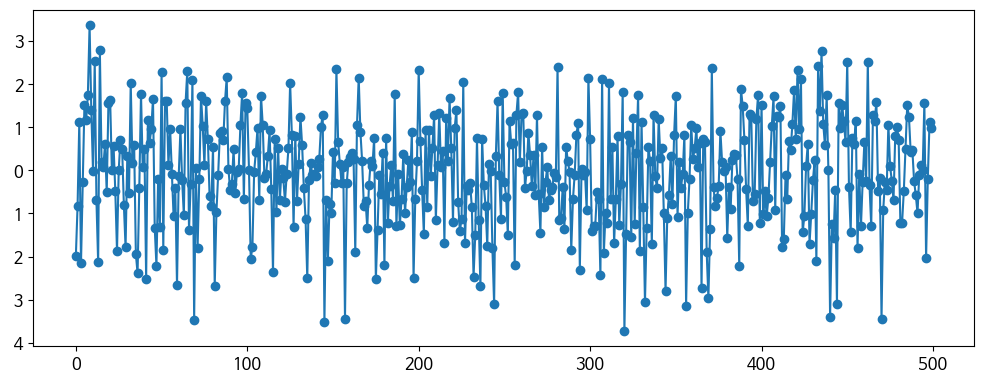

<ipython-input-18-ccbbe536dc6d>:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


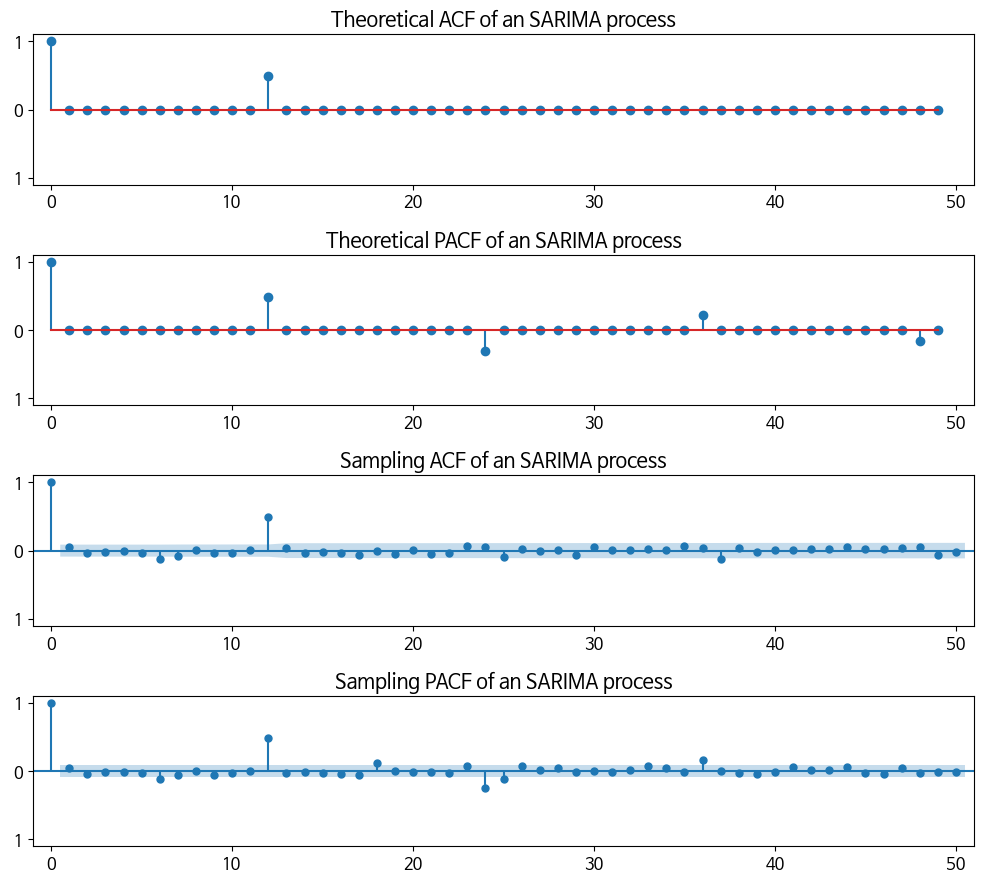

In [ ]:
# SARIMA(0,0,0)(0,0,1,12)
plt.figure(figsize=(10, 4))
np.random.seed(123)
ar_params = np.array([])
ma_params = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.78])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical ACF of an SARIMA process")

plt.subplot(412)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical PACF of an SARIMA process")

sm.graphics.tsa.plot_acf(y, lags=50, ax=plt.subplot(413))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling ACF of an SARIMA process")

sm.graphics.tsa.plot_pacf(y, lags=50, ax=plt.subplot(414))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling PACF of an SARIMA process")
plt.tight_layout()
plt.show()

### <Case 2>

- **SARIMA(0,0,0)(1,0,0,12):**

$$
(1 - \Phi_{1}L^{12}) Y_{t} = \epsilon_t
$$

$$
Y_t = \Phi Y_{t-12} + \epsilon_t
$$

> - ACF : 반복되는 계절성시차들의 지수적 감소  
> - PACF : 계절성시차(Lag12)에서의 계수가 유의수준을 벗어난 증가 확인 (다른 시차에서는 유의수준 이내)  

<ipython-input-8-b7ece9b80a68>:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


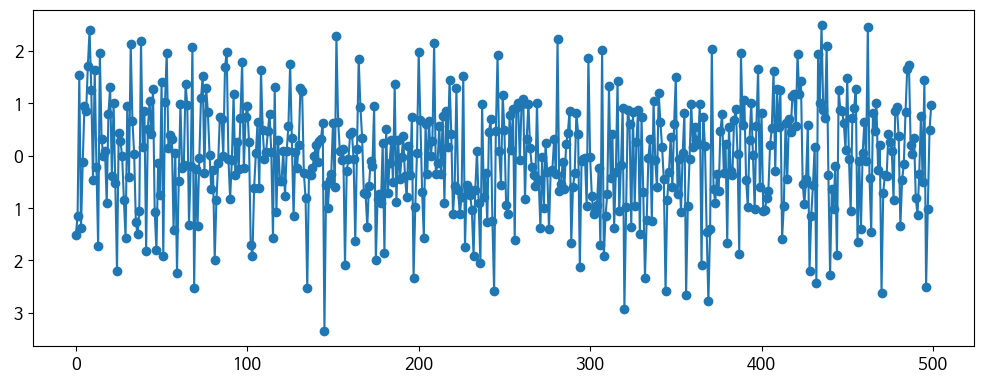

<ipython-input-8-b7ece9b80a68>:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


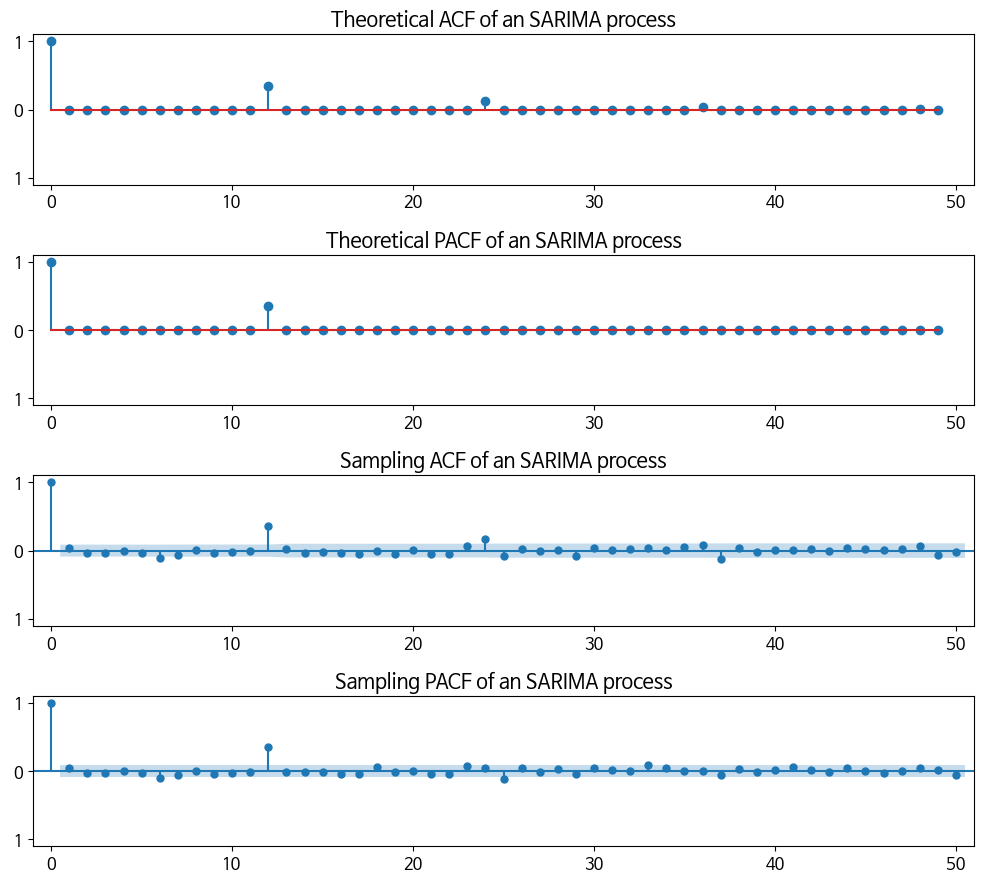

In [ ]:
# SARIMA(0,0,0)(1,0,0,12)
plt.figure(figsize=(10, 4))
np.random.seed(123)
ar_params = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.35])
ma_params = np.array([])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical ACF of an SARIMA process")

plt.subplot(412)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical PACF of an SARIMA process")

sm.graphics.tsa.plot_acf(y, lags=50, ax=plt.subplot(413))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling ACF of an SARIMA process")

sm.graphics.tsa.plot_pacf(y, lags=50, ax=plt.subplot(414))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling PACF of an SARIMA process")
plt.tight_layout()
plt.show()

### <Case 3>

- **SARIMA(0,0,1)(0,0,1,12):**

$$
Y_t = (1+\theta L)(1+\Theta L^{12}) \epsilon_t = \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta\Theta \epsilon_{t-13} \\
$$


Sesonality 12, 계절주기 자료 ARIMA(0,0,1), 비계절 자료 ARIMA(0,0,1)  
> - 시차(Lag)가 1, 11, 12, 13인 경우를 제외하고는 자기상관계수가 모두 0

<ipython-input-19-d5b2fcaf7280>:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


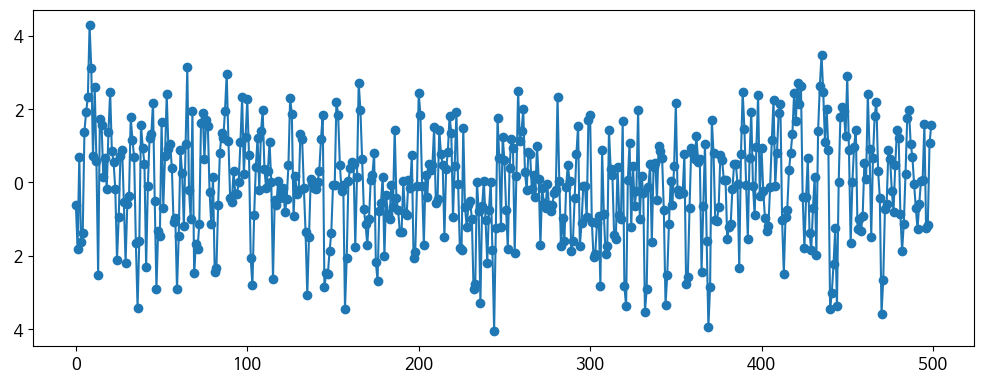

<ipython-input-19-d5b2fcaf7280>:36: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


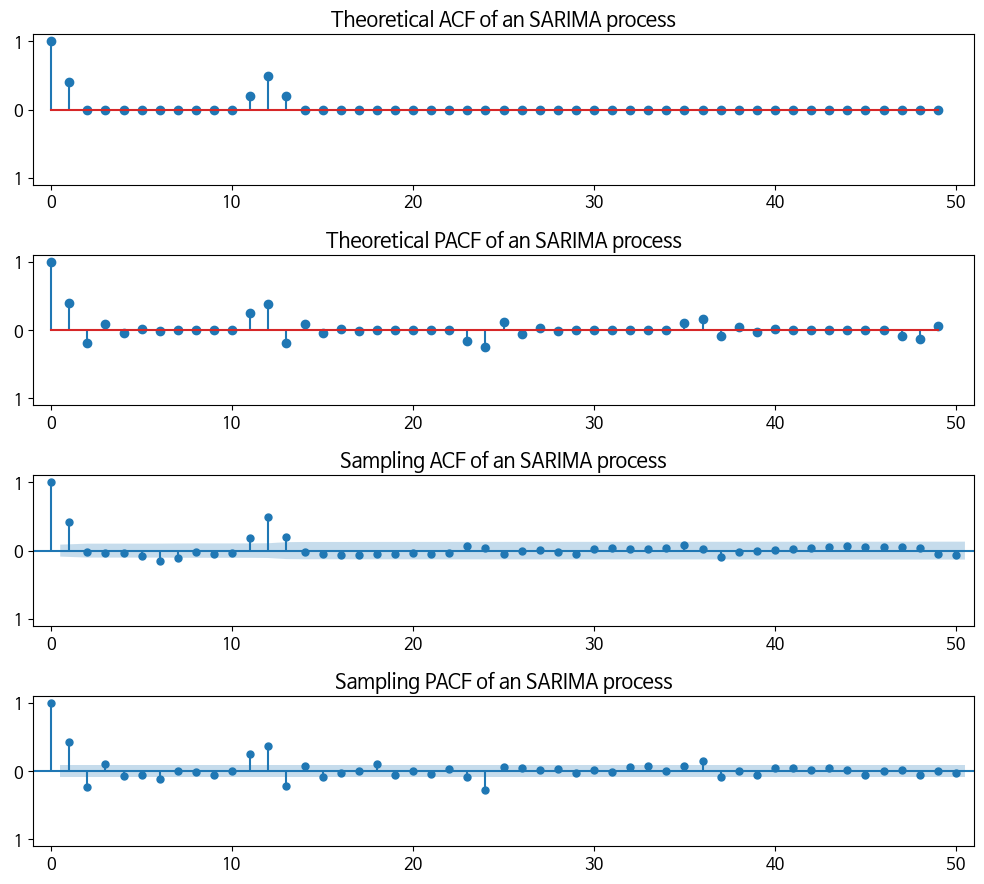

In [ ]:
# SARIMA(0,0,1)(0,0,1,12)
plt.figure(figsize=(10, 4))
np.random.seed(123)
phi, Phi = 0, 0
theta, Theta = 0.5, 0.8
ar_params = np.array([])
ma_params = np.array([theta, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Theta, theta*Theta])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical ACF of an SARIMA process")

plt.subplot(412)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical PACF of an SARIMA process")

sm.graphics.tsa.plot_acf(y, lags=50, ax=plt.subplot(413))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling ACF of an SARIMA process")

sm.graphics.tsa.plot_pacf(y, lags=50, ax=plt.subplot(414))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling PACF of an SARIMA process")
plt.tight_layout()
plt.show()

### <Case 4>

- **SARIMA(0,0,1)(1,0,0,12):**

Sesonality 12, 계절주기 자료들 간에는 ARIMA(1,0,0), 비계절 자료들 간에는 ARIMA(0,0,1)  
> - 시차(Lag)가 12의 배수와 그 앞/뒤인 경우(12$k$, 12$k$+1, 12$k$-1)를 제외하고는 자기상관계수가 모두 0

$$
(1 - \Phi L^{12})Y_t = (1 + \theta L) \epsilon_t \\
Y_t =  \Phi Y_{t-12} + \epsilon_t + \theta \epsilon_{t-1}
$$

<ipython-input-20-c256aca65ca6>:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


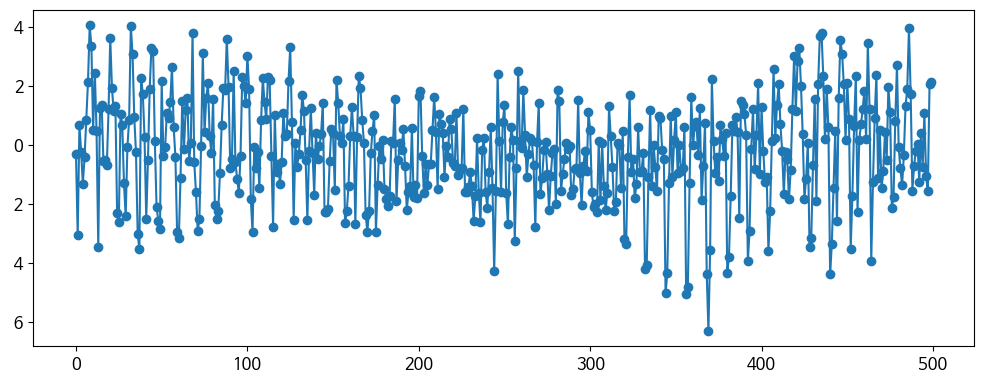

<ipython-input-20-c256aca65ca6>:36: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


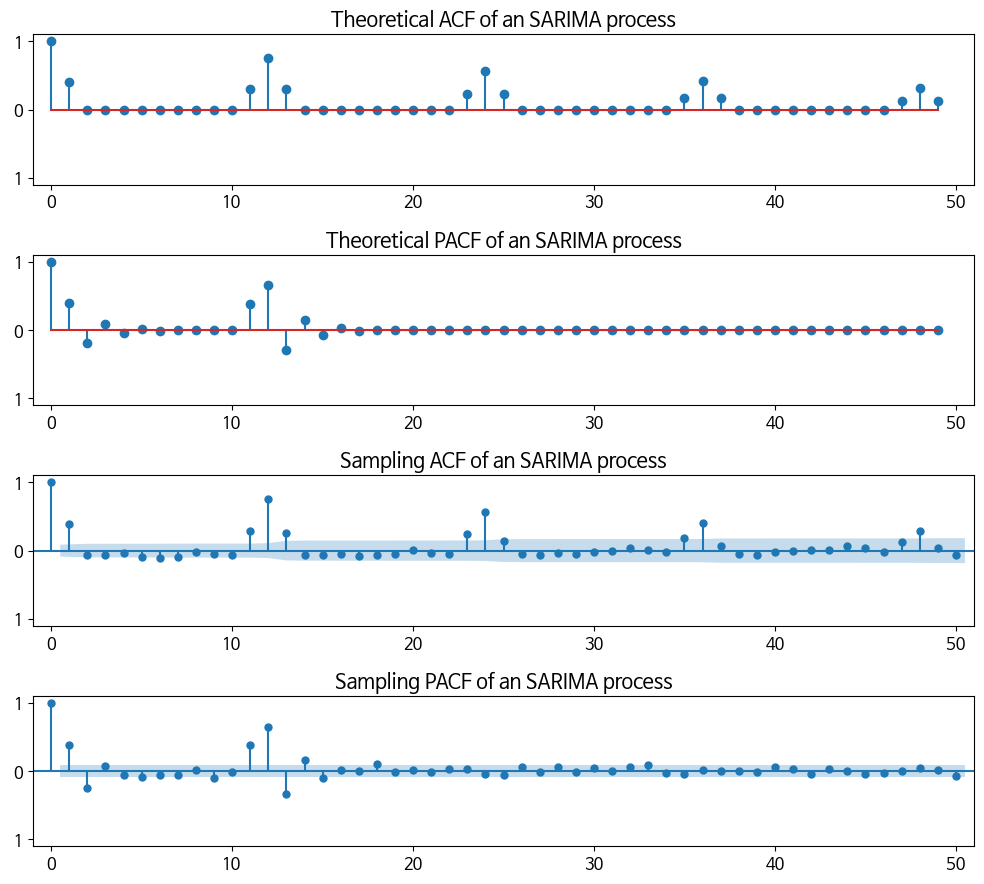

In [ ]:
# SARIMA(0,0,1)(1,0,0,12)
plt.figure(figsize=(10, 4))
np.random.seed(123)
phi, Phi = 0, 0.75
theta, Theta = 0.5, 0
ar_params = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Phi])
ma_params = np.array([theta])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical ACF of an SARIMA process")

plt.subplot(412)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical PACF of an SARIMA process")

sm.graphics.tsa.plot_acf(y, lags=50, ax=plt.subplot(413))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling ACF of an SARIMA process")

sm.graphics.tsa.plot_pacf(y, lags=50, ax=plt.subplot(414))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling PACF of an SARIMA process")
plt.tight_layout()
plt.show()

### <Case 5>

- **SARIMA(0,1,0)(0,1,0,12):**

$$
Y_t - Y_{t-1} - Y_{t-12} + Y_{t-13} = \epsilon_t \\
Y_t = Y_{t-1} + Y_{t-12} - Y_{t-13} + \epsilon_t
$$


Sesonality 12, 계절주기 자료 ARIMA(0,1,0), 비계절 자료 ARIMA(0,1,0)  
> - 시계열 1차 차분 이후 다시 12간격 차분하면 White noise

<ipython-input-21-e2ac5680612e>:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


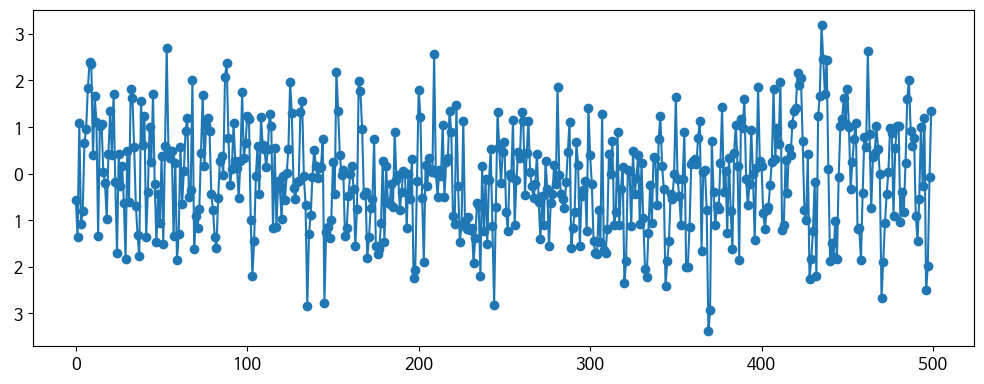

<ipython-input-21-e2ac5680612e>:36: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


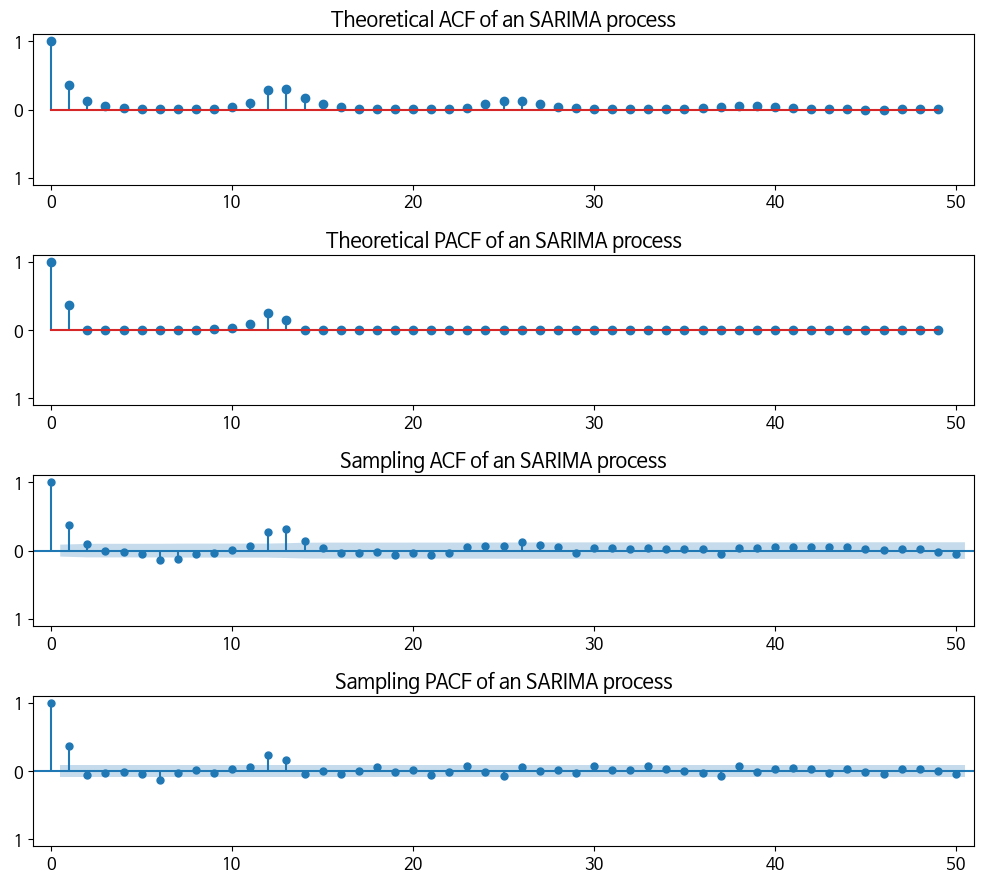

In [ ]:
# SARIMA(0,1,0)(0,1,0,12)
plt.figure(figsize=(10, 4))
np.random.seed(123)
# phi, Phi = 0, 0
# theta, Theta = 0.5, 0.8
ar_params = np.array([0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.15])
ma_params = np.array([])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical ACF of an SARIMA process")

plt.subplot(412)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=50))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical PACF of an SARIMA process")

sm.graphics.tsa.plot_acf(y, lags=50, ax=plt.subplot(413))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling ACF of an SARIMA process")

sm.graphics.tsa.plot_pacf(y, lags=50, ax=plt.subplot(414))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Sampling PACF of an SARIMA process")
plt.tight_layout()
plt.show()

# SARIMA 모델링 정리
#### (파이썬을활용한시계열데이터분석, 김경원, Fast Campus 강좌 인용)

- **예시:**  

> <center><img src = 'https://drive.google.com/uc?id=1-3nxFFQqUjC7TQZJTwja7OYJDIrFgjqm' height = 400 width = 700>
</center>

> - $p:2?$ (PACF 기준 lag 2까지 유의하고 그 뒤로는 유의하지 않음)  
> - $d:1?$ (ADF가 대중가설을 기각하므로 추세 1차 차분)  
> - $q:1?$ (ACF 기준 필요성 인지)  
> - $P:1?$ (PACF 기준 lag 24 간격 유의성으로 필요성 인지)    
> - $D:1?$ (계절성 차분 필요함 인지)  
> - $Q:2?$ (ACF 기준 lag 24 간격 유의성으로 필요성 인지)  
> - $m:24?$ (ACF/PACF 기준 lag 24 간격으로 유의한 진동 존재)  

> (계절차분 후 데이터)  
> <center><img src = 'https://drive.google.com/uc?id=1ke148sYwjg7wmfJmpj6r2Sf6szUTioSJ' height = 400 width = 700>
</center>


> - $p:1?$ (PACF 기준 lag 1까지 유의하고 그 뒤로는 유의하지 않음)  
> - $d:1?$ (ADF가 대중가설을 기각하고 그래프 상 추세가 보이므로 일단 추세 1차 차분)  
> - $q:3?$ (ACF 기준 필요성 인지)  
> - $P:2?$ (PACF 기준 lag 24 간격 유의성으로 필요성 인지)    
> - $D:1$ (계절성 차분 필요)  
> - $Q:0?$ (ACF 기준 lag 24 간격 유의성으로 필요성 인지)  
> - $m:24$ (ACF/PACF 기준 lag 24 간격으로 유의한 진동 크게 사라짐)  

> (계절성 및 추세차분 후 데이터)  
> <center><img src = 'https://drive.google.com/uc?id=16LbZQ9CjQGQADurgN22Jq2J9FaNcTR7h' height = 400 width = 700>
</center>

> - $p:max4$ (PACF 기준 lag 4까지 유의하고 그 뒤로는 유의하지 않음)  
> - $d:1$ (ADF가 대중가설을 기각하고 그래프 상 추세도 없어졌으므로 추세 1차 차분 확정)  
> - $q:max4$ (ACF 기준 lag 4까지 유의하고 그 뒤로는 유의하지 않음)  
> - $P:max2$ (PACF 기준 lag 24 간격으로 2번정도 유의함)    
> - $D:1$ (계절성 차분 필요함 인지)  
> - $Q:max1$ (ACF 기준 lag 24 간격으로 1번정도 유의함)  
> - $m:24$ (lag 24 간격으로 진동 존재)  

> (잔차검증)
> <center><img src = 'https://drive.google.com/uc?id=17mhgQ61NNm8hYlH1Sm5chfjd-Wt4S3hc' height = 400 width = 700>
</center>


In [ ]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

TypeError: ignored

# 시계열 데이터 분석 사례

## 항공수요 예측

,Stationarity_adf
Statistics,0.815369
p_value,0.991880
Critical Value(1%),-3.481682
Maximum Information Criteria,996.692931


<ipython-input-12-3d5cc5e1cc11>:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


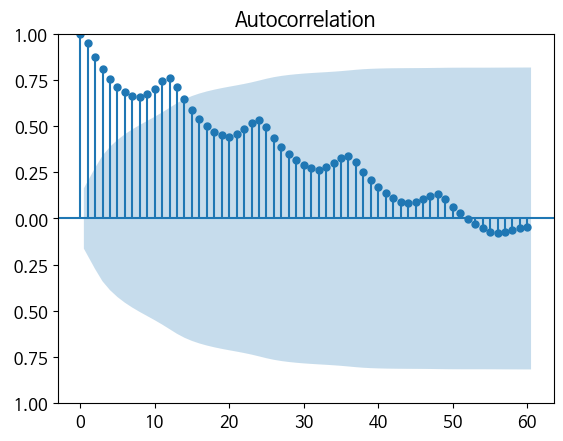

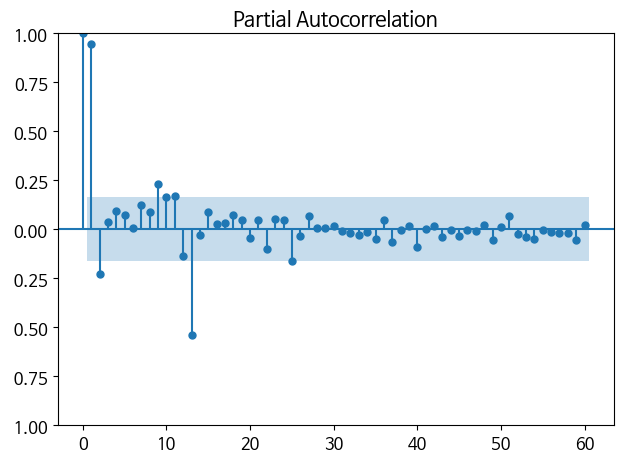

,Stationarity_adf
Statistics,-1.717017
p_value,0.422367
Critical Value(1%),-3.481682
Maximum Information Criteria,-445.399031


<ipython-input-12-3d5cc5e1cc11>:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


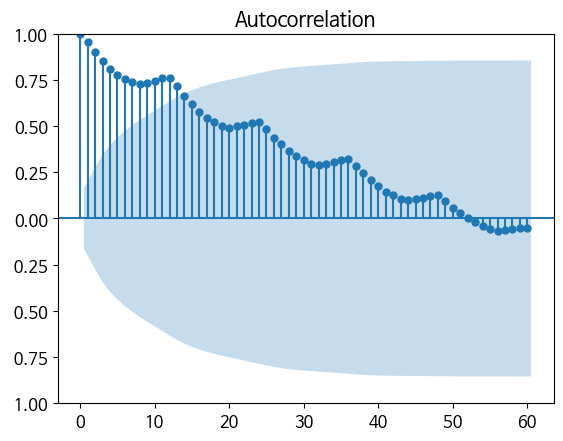

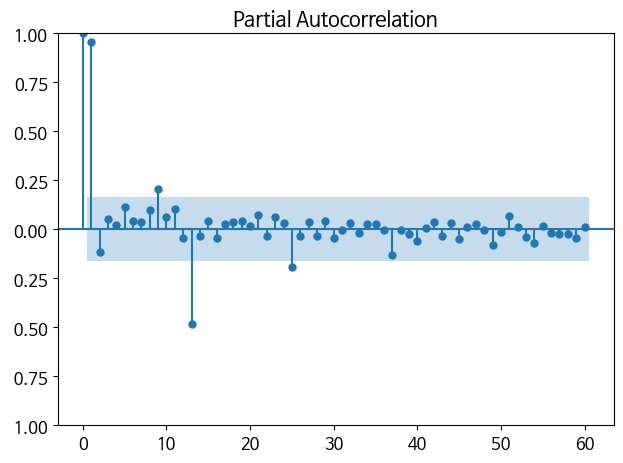

,Stationarity_adf
Statistics,-2.717131
p_value,0.071121
Critical Value(1%),-3.482501
Maximum Information Criteria,-440.358470


<ipython-input-12-3d5cc5e1cc11>:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


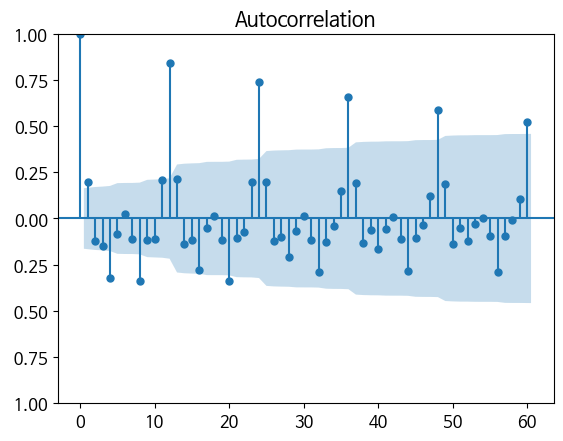

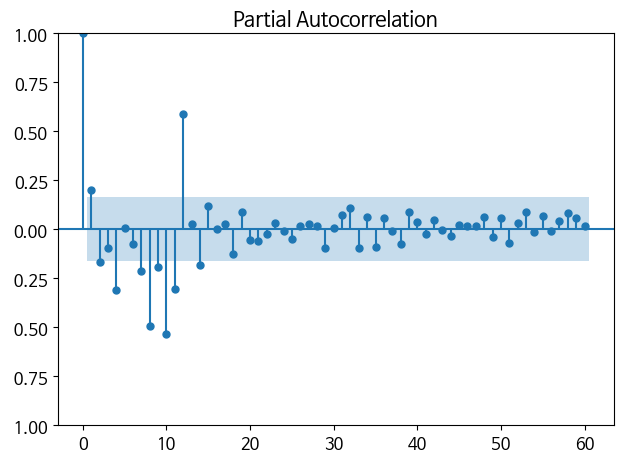

In [ ]:
#%reload_ext autoreload
#%autoreload 2
#%from module import stationarity_adf_test, stationarity_kpss_test

# 데이터 준비
data = sm.datasets.get_rdataset("AirPassengers")
raw = data.data.copy()

# 데이터 전처리
## 시간 인덱싱
if 'time' in raw.columns:
    raw.index = pd.date_range(start='1/1/1949', periods=len(raw['time']), freq='M')
    del raw['time']

## 정상성 테스트
### 미변환
raw_data = raw.copy()
display(stationarity_adf_test(raw_data.values.flatten(), []))
sm.graphics.tsa.plot_acf(raw_data, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(raw_data, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()

# ### 로그 변환
log_data = np.log(raw).copy()
display(stationarity_adf_test(log_data.values.flatten(), []))
sm.graphics.tsa.plot_acf(log_data, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(log_data, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()

### 로그+추세차분 변환

## 추세 차분계수 설정
trend_order = 1

log_data_diff = log_data.diff(trend_order).dropna().copy()
display(stationarity_adf_test(log_data_diff.values.flatten(), []))
sm.graphics.tsa.plot_acf(log_data_diff, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(log_data_diff, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()


In [ ]:
raw_data.values.flatten()

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])

In [ ]:
# 가장 큰 값을 추출하여 seasonal order를 추정해 본다
seasonal_order = sm.tsa.acf(log_data_diff)[1:].argmax() + 1
print('Seasonal Diff: ', seasonal_order)

Seasonal Diff:  12


,Stationarity_adf
Statistics,-4.443325
p_value,0.000249
Critical Value(1%),-3.487022
Maximum Information Criteria,-415.559753


<ipython-input-27-acbb15c1789e>:6: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


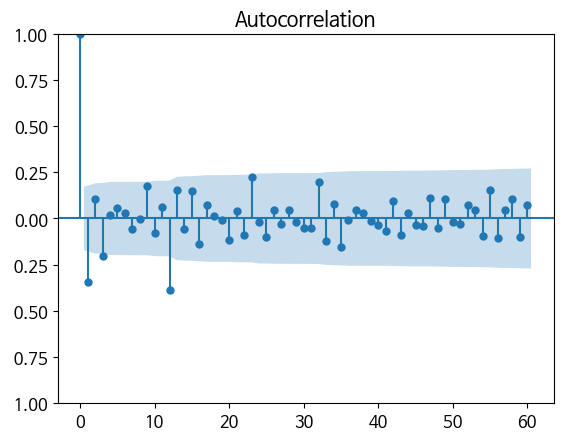

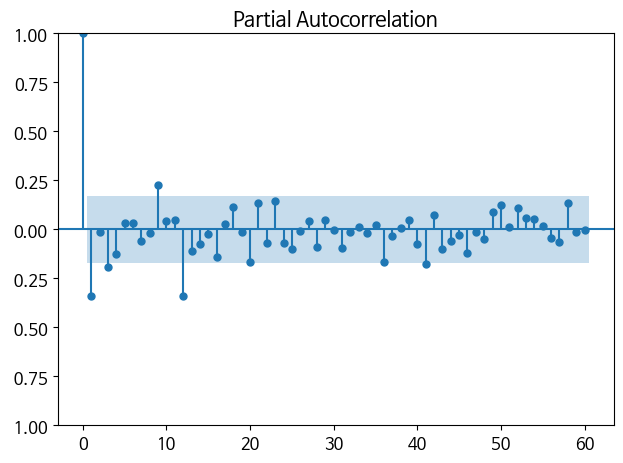

In [ ]:
### 로그+추세차분+계절차분 변환
log_data_diff_SA = log_data_diff.diff(seasonal_order).dropna().copy()
display(stationarity_adf_test(log_data_diff_SA.values.flatten(), []))
sm.graphics.tsa.plot_acf(log_data_diff_SA, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(log_data_diff_SA, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


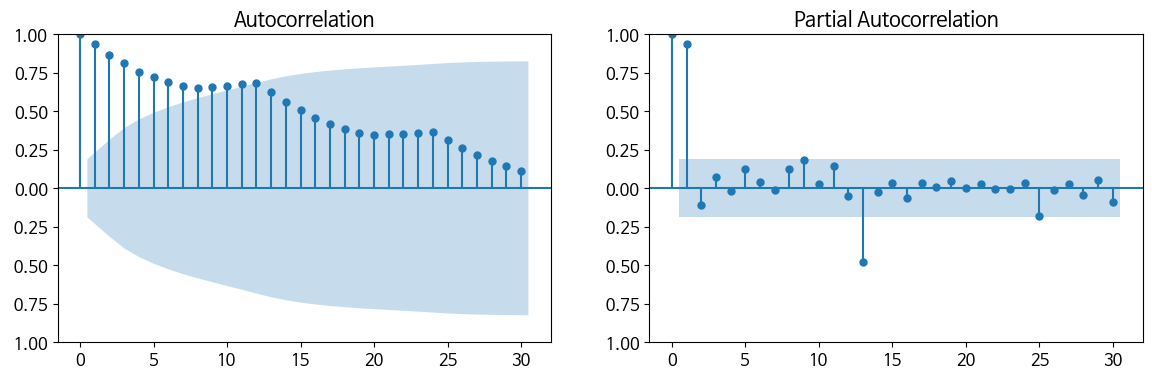

In [ ]:
## 최종 타겟 선정 및 Train/Test 데이터 분리
target_df = log_data.copy()
split_dt = '1958-01-01'
Y_train = target_df[target_df.index < split_dt]
Y_test = target_df[target_df.index >= split_dt]

## 시각화 와 모수추론(p=1, q=0, d=1, P=1, Q=1, D(m)=12)
plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train, lags=30, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train, lags=30, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.show()

In [ ]:
# 모델링
## SARIMAX
logarithm, differencing = True, False

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train, order=(1,trend_order,1),
                                seasonal_order=(1,1,1,seasonal_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_train_sarimax = fit_ts_sarimax.predict()
pred_test_sarimax = fit_ts_sarimax.get_forecast(len(Y_test)).predicted_mean
pred_test_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test)).conf_int()

# ## 비정상성으로 변환
if logarithm:
    Y_train_re = np.exp(Y_train).copy()
    Y_test_re = np.exp(Y_test).copy()
    pred_tr_sarimax = np.exp(pred_train_sarimax).copy()
    pred_te_sarimax = np.exp(pred_test_sarimax).copy()
    pred_te_sarimax_ci = np.exp(pred_test_sarimax_ci).copy()

if differencing:
    pred_tr_sarimax = np.cumsum(pred_train_sarimax).copy()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 175.046
Date:                            Sat, 11 Nov 2023   AIC                           -338.092
Time:                                    07:14:00   BIC                           -322.768
Sample:                                01-31-1949   HQIC                          -331.900
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.232e-05      0.002      0.027      0.979      -0.003       0.003
ar.L1         -0.1041      0.296     -0.351      0.725      -0.685       0.476
ma.L1         -0.2517      0.316     -0.795      0.426      -0.872       0.369
ar.S.L12       0.0062      0.233      0.027      0.979      -0.450       0.462
ma.S.L12      -0.6100      0.268     -2.273      0.023      -1.136      -0.084
sigma2         0.0014      0.000      7.125      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               0.28   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,18.555576,12096.664157,13.542432
Test,32.891439,1287.665285,7.923816


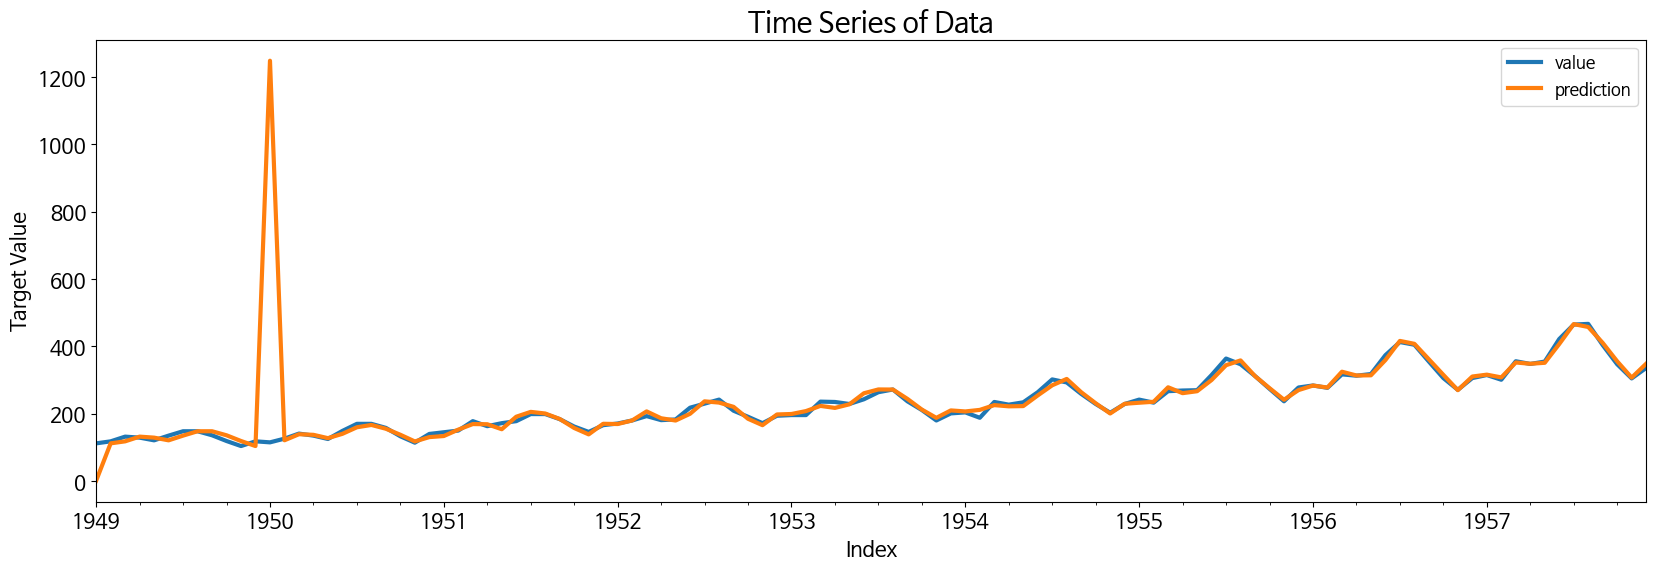

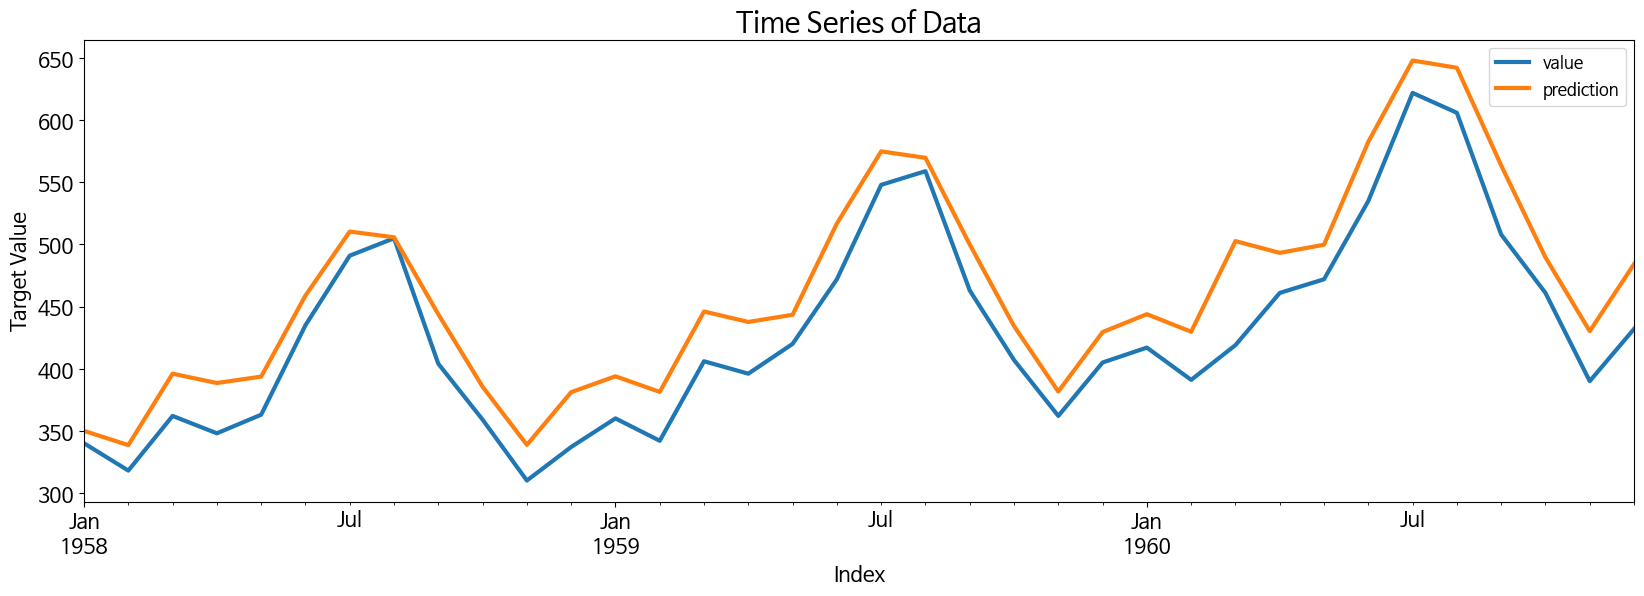

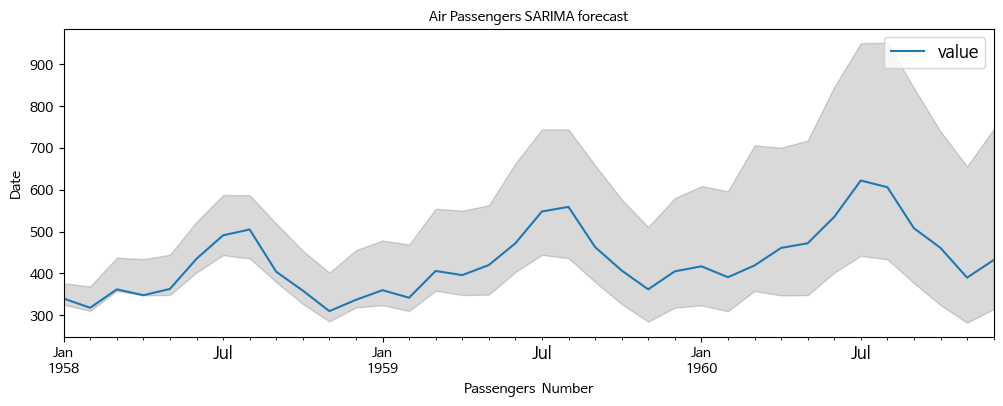

In [ ]:
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_re, pred_tr_sarimax,
                                                                             Y_test_re, pred_te_sarimax, graph_on=True)
display(Score_ts_sarimax)

ax = pd.DataFrame(Y_test_re).plot(figsize=(12,4))

ax.fill_between(pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).index,
                pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).iloc[:,0],
                pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).iloc[:,1], color='k', alpha=0.15)


# Title 설정
ax.set_title("Air Passengers SARIMA forecast", fontsize=10)
# x축 레이블 설정
ax.set_xlabel("Passengers  Number", fontsize=10)
# y축 레이블 설정
ax.set_ylabel("Date", fontsize=10)

# x축 눈금 값 설정
plt.xticks(fontsize=10)
# y축 눈금 값 설정
plt.yticks(fontsize=10)

plt.show()

# 잔차진단
#error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train, graph_on=True)